The task is to build a neural network that detects which types of clothing appear in an image. Each image can contain multiple clothing items, and the model should predict all relevant labels for each image.

#Starter code
provided by the competition organizers

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as fun
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import f1_score

In [2]:
def seed_everything(seed: int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

N_CLASSES: int = 10
LABEL_NAMES: dict[int, str] = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

FILES: list[str] = [
        "runway-mnist/train-x.npz",
        "runway-mnist/train-y.npz",
        "runway-mnist/val-x.npz",
        "runway-mnist/val-y.npz"
    ]

if not all(os.path.exists(file) for file in FILES):
        import gzip
        import tarfile
        import shutil

        if not os.path.exists("runway-mnist"):
            os.mkdir("runway-mnist")

        COMPRESSED_ARCHIVE = "runway-mnist.tar.gz"
        TAR_ARCHIVE  = COMPRESSED_ARCHIVE.rstrip(".gz")
        DOWNLOAD_URL = "https://drive.google.com/uc?id=1oNAFYdJyCVe3Po90KLUPxAG9HGuL7NSw"

        try:
            import gdown
        except ImportError as err:
            raise RuntimeError("Do pobrania zbioru danych potrzebujesz lokalnej instalacji pakietu gdown: `pip install gdown`") from err

        gdown.download(DOWNLOAD_URL, str(COMPRESSED_ARCHIVE), quiet=False)

        with gzip.open(COMPRESSED_ARCHIVE, "rb") as compressed:
            with open(TAR_ARCHIVE, "wb") as archive:
                shutil.copyfileobj(compressed, archive)

        os.remove(COMPRESSED_ARCHIVE)
        print(f"Zdekompresowano: {TAR_ARCHIVE}")

        with tarfile.open(TAR_ARCHIVE, "r") as tar:
            tar.extractall("runway-mnist")

        os.remove(TAR_ARCHIVE)
        print(f"Rozpakowano: {TAR_ARCHIVE}")

SEED: int = 42
seed_everything(SEED)

def load_x(usage) -> torch.Tensor:
    path = f"runway-mnist/{usage}-x.npz"
    return torch.tensor(np.load(path)["images"], dtype=torch.float32).unsqueeze(1)

def load_y(usage) -> torch.Tensor:
    path = f"runway-mnist/{usage}-y.npz"
    return torch.tensor(np.load(path)["labels"], dtype=torch.long)

train_dataset = TensorDataset(load_x("train"), load_y("train"))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(load_x("val"), load_y("val"))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


def compute_score(f1: float) -> int:
    lower_bound = 0.57
    upper_bound = 0.87

    if f1 <= lower_bound:
        return 0
    elif lower_bound < f1 < upper_bound:
        return int(round(100 * (f1 - lower_bound) / (upper_bound - lower_bound)))
    else:
        return 100

def evaluate_algorithm(model, predict, loader) -> float:
    preds = []
    labels = []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            prediction = predict(model, x.to(device)).cpu()
            preds.append(prediction)
            labels.append(y)

    predictions = torch.cat(preds)
    labels = torch.cat(labels)

    f1 = f1_score(labels.numpy(), predictions.numpy(), average="macro")
    points = compute_score(f1)
    print(f"F1 score: {f1:.3f}, {points} points")
    return f1

cuda


#My solution

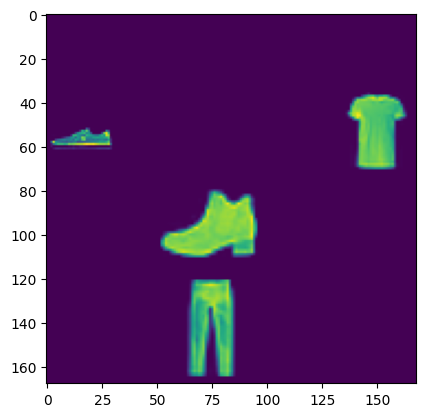

In [3]:
import matplotlib.pyplot as plt
img = train_dataset[3][0].squeeze()
plt.imshow(img)
plt.show()

In [4]:
[LABEL_NAMES[i] for i, v in enumerate(train_dataset[3][1]) if v == 1]

['T-shirt/top', 'Trouser', 'Sneaker', 'Ankle boot']


This solution fine-tunes a pretrained ResNet-18 for multi-label image classification by replacing its final layer, training it with BCEWithLogitsLoss, and predicting labels using sigmoid + thresholding (0.5).

In [5]:
#Tomasz Uram
class Solution(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, N_CLASSES)
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.model(input)

def train_solution(_: Solution):
    model = _
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    EPOCHS = 7

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0

        for images, targets in train_loader:
            images = images.to(device)
            if images.shape[1] == 1:
                images = images.repeat(1, 3, 1, 1)

            targets = targets.float().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = model.criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        print(f"Epoch [{epoch+1}/{EPOCHS}] | train_loss: {train_loss:.4f}")
def predict_solution(model: Solution, input: torch.Tensor) -> torch.Tensor:
    if input.shape[1] == 1:
      input = input.repeat(1, 3, 1, 1)
    with torch.no_grad():
        outputs = model(input)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).long()
    return preds

In [6]:
solution = Solution().to(device)
solution.train()
train_solution(solution)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/7] | train_loss: 0.4464
Epoch [2/7] | train_loss: 0.2603
Epoch [3/7] | train_loss: 0.1842
Epoch [4/7] | train_loss: 0.1225
Epoch [5/7] | train_loss: 0.0760
Epoch [6/7] | train_loss: 0.0476
Epoch [7/7] | train_loss: 0.0336


In [7]:
evaluate_algorithm(solution, predict_solution, val_loader)

F1 score: 0.866, 99 points


0.8658937304672032